__[Data Documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt)__

In [353]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, normalize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split

%matplotlib inline

# Setting some default graph styles
sns.set_style("white", {'axes.edgecolor': '#b2b2b2'})
sns.set_context("notebook", font_scale=1.25)

In the initial analysis of the data documentation, it became clear that the data made extensive use of the value 'NA' to indicate that a feature of the house was not present.  For instance, the Garage Finish feature is described thusly:

Garage Finish (Ordinal)	: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage


In this case 'NA' does not mean "no data about the Garage Finish was recorded".  It means "we know that this house does not have a garage, therefore there is no data about the Garage Finish".  This is an important distinction as the NA value does indeed tell us something about the house.  

That being said, let's remove 'NA' from the list of things Pandas looks for when deciding if a field is empty.

In [354]:
# Redefining the list of items Pandas considers empty

na_list = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan',
    '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan',
    'null']

In [355]:
housing = pd.read_csv('AmesHousing.tsv', '\t', 
                      na_values=na_list, keep_default_na=False)

In [356]:
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


# Data Analysis and Cleaning

First let's see how the data looks with regard to missing values.

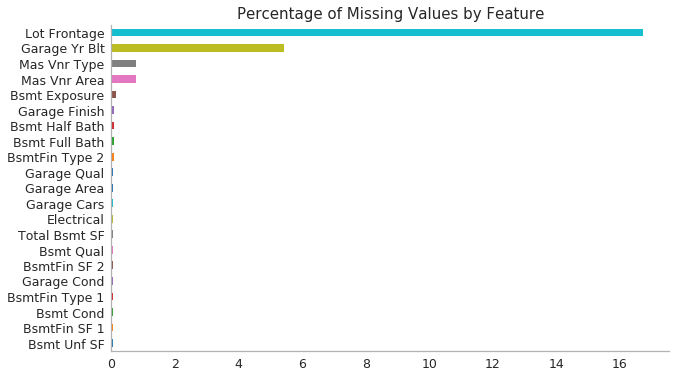

In [357]:
def missing_data(df, thresh=None):

    missing_vals = df.isnull().sum()
    missing_vals = missing_vals[missing_vals > 0]
    missing_vals = missing_vals.apply(lambda x: x / df.shape[0] * 100)
    
    if thresh:
        
        missing_vals = missing_vals[missing_vals > thresh]
    
    missing_vals = missing_vals.sort_values()
    
    return missing_vals
  
    
missing_data(housing).sort_values().plot(kind='barh', figsize=(10,6))    
plt.title('Percentage of Missing Values by Feature')
sns.despine()

The data documentation states the following about these features:

* Lot Frontage (Continuous): Linear feet of street connected to property
* Garage Yr Blt (Discrete): Year garage was built
* Mas Vnr Type (Nominal): Masonry veneer type
* Mas Vnr Area (Continuous): Masonry veneer area in square feet
* Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls
* Garage Finish (Ordinal)	: Interior finish of the garage
* Bsmt Half Bath (Discrete): Basement half bathrooms
* Bsmt Full Bath (Discrete): Basement full bathrooms
* BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)
* Garage Qual (Ordinal): Garage quality
* Garage Area (Continuous): Size of garage in square feet
* Garage Cars (Discrete): Size of garage in car capacity
* Electrical (Ordinal): Electrical system
* Total Bsmt SF (Continuous): Total square feet of basement area
* Bsmt Qual (Ordinal): Evaluates the height of the basement
* BsmtFin SF 2 (Continuous): Type 2 finished square feet
* Garage Cond (Ordinal): Garage condition
* BsmtFin Type 1 (Ordinal): Rating of basement finished area
* Bsmt Cond (Ordinal): Evaluates the general condition of the basement
* BsmtFin SF 1 (Continuous): Type 1 finished square feet
* Bsmt Unf SF (Continuous): Unfinished square feet of basement area


Let's first address Lot Frontage.  The data set contains a feature called Lot Config, which is described thusly:

Lot Config (Nominal): Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
       
Based on research into these different lot types from this source __[Real Estate Lot Types](https://www.thetruthaboutrealty.com/real-estate-lot-types/)__, all five of those lot configurations indicate some frontage to the street.  Since we know that there are no observations missing a "Lot Config" value, we can conclude that every observation should have some measureable length of Lot Frontage.

The Lot Config could potentially lead to very large differences in Lot Frontage (imagine the same house/lot as an Inside lot vs. a FR3 lot).  Rather than taking the mean of the entire feature for imputation, let's use the mean from each Lot Type and fill in accordingly.

In [358]:
lot_configs = housing['Lot Config'].unique()

In [359]:
def dict_fill(input_list, target, target_val, default_val):
    
    target_dict = {}
    
    for item in input_list:
        
        if item == target:
            target_dict[item] = target_val
        else:
            target_dict[item] = default_val
            
    return target_dict

In [360]:
def cond_fill(row, test_col, target_col, values):
    
    if pd.isnull(row[test_col]) or (not pd.isnull(row[target_col]) and row[target_col] != 'NA'):
        return row[target_col]
    
    else:
        return values.get(row[test_col], row[target_col])

In [361]:
# Making a dictionary of Lot Frontage means based on Lot Config and
# conditionally filling in the missing Lot Frontage values

lot_conf_means = {}

for config in lot_configs:
    lot_conf_means[config] = housing[housing['Lot Config'] == config]['Lot Frontage'].mean()
    
housing['Lot Frontage'] = housing.apply(cond_fill, args=('Lot Config', 'Lot Frontage', lot_conf_means), axis=1)
housing['Lot Frontage'].isnull().sum()

0

Let's look at the missing Garage features as a group to get an idea of what is going on with their missing values.

In [362]:
myre = re.compile("^Garage.*")
garage_feat = [name for name in housing.columns if myre.match(name)]

In [369]:
housing[(housing[garage_feat].isnull().any(axis=1))][garage_feat].style.highlight_null(null_color='orange')

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond


Let's use Garage Type as an indicator of whether or not a house has a Garage.  With that in mind let's see what the most plentiful entries are for the categorical Garage features.

In [364]:
# Retrieving the mode for the three categorical Garage features

garage_finish_mode = housing['Garage Finish'].mode()[0]
garage_qual_mode = housing['Garage Qual'].mode()[0]
garage_cond_mode = housing['Garage Cond'].mode()[0]

In [365]:
garage_types = housing['Garage Type'].unique()
garage_finish_dict = dict_fill(garage_types, 'NA', 'NA', garage_finish_mode)
garage_qual_dict = dict_fill(garage_types, 'NA', 'NA', garage_qual_mode)
garage_cond_dict = dict_fill(garage_types, 'NA', 'NA', garage_cond_mode)

In [366]:
housing['Garage Finish'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Finish', garage_finish_dict), axis=1)
housing['Garage Qual'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Qual', garage_qual_dict), axis=1)
housing['Garage Cond'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Cond', garage_cond_dict), axis=1)

Now for the continuous features.  If a house has a Garage Type set but nothing in the Garage Cars or Garage Area, we'll set Garage Cars to 1 and set the Garage Area to the mean value for single car garages.

In [367]:
garage_area_mean = housing[housing['Garage Cars'] == 1]['Garage Area'].mean()

garage_cars_dict = dict_fill(garage_types, 'NA', 0, 1)
garage_area_dict = dict_fill(garage_types, 'NA', 0, garage_area_mean)

housing['Garage Cars'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Cars', garage_cars_dict), axis=1)
housing['Garage Area'] = housing.apply(cond_fill, args=('Garage Type', 'Garage Area', garage_area_dict), axis=1)

Finally, let's fill in Garage Yr Blt with 0 if it is missing. We'll be creating a new binary feature later that indicates if the house has a garage or not.  

In [368]:
housing['Garage Yr Blt'].fillna(0, inplace=True)

For ***Mas Vnr Type*** and ***Mas Vnr Area*** let's assume that if these values are missing then the house has no Masonry Veneer.  We'll set ***Mas Vnr Type*** to 'None' and ***Mas Vnr Area*** to 0.

In [342]:
housing['Mas Vnr Type'].fillna('None', inplace=True)
housing['Mas Vnr Area'].fillna(0, inplace=True)

Let's look at the missing Basement features as a group to get an idea of what is going on with their missing values.

In [343]:
myre = re.compile(".*Bsmt.*")

bsmt_feat = [name for name in housing.columns if myre.match(name)]

In [351]:
# Grabbing any row where any Basement feature is NaN

housing[(housing[bsmt_feat].isnull().any(axis=1))][bsmt_feat].style.highlight_null(null_color='orange')

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath


Let's use Bsmt Qual as the indicator of whether or not the house has a basement.  If it is null then we'll subtitute NA 

In [347]:
housing['Bsmt Qual'].fillna(value='NA', inplace=True)

If Bsmt Qual is NA then all of the other Basement features should be NA or 0

In [348]:
housing['Bsmt Cond'].mask((pd.isnull(housing['Bsmt Cond'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['Bsmt Exposure'].mask((pd.isnull(housing['Bsmt Exposure'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['BsmtFin Type 1'].mask((pd.isnull(housing['BsmtFin Type 1'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['BsmtFin SF 1'].mask((pd.isnull(housing['BsmtFin SF 1'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['BsmtFin Type 2'].mask((pd.isnull(housing['BsmtFin Type 2'])) & (housing['Bsmt Qual'] == 'NA'), 'NA', inplace=True)
housing['BsmtFin SF 2'].mask((pd.isnull(housing['BsmtFin SF 2'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Bsmt Unf SF'].mask((pd.isnull(housing['Bsmt Unf SF'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Total Bsmt SF'].mask((pd.isnull(housing['Total Bsmt SF'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Bsmt Full Bath'].mask((pd.isnull(housing['Bsmt Full Bath'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)
housing['Bsmt Half Bath'].mask((pd.isnull(housing['Bsmt Half Bath'])) & (housing['Bsmt Qual'] == 'NA'), 0, inplace=True)

Filling in the remaining missing Basement features

In [350]:
housing['Bsmt Exposure'].fillna(value='No', inplace=True)
housing['BsmtFin Type 2'].fillna(value=housing['BsmtFin Type 2'].mode()[0], inplace=True)

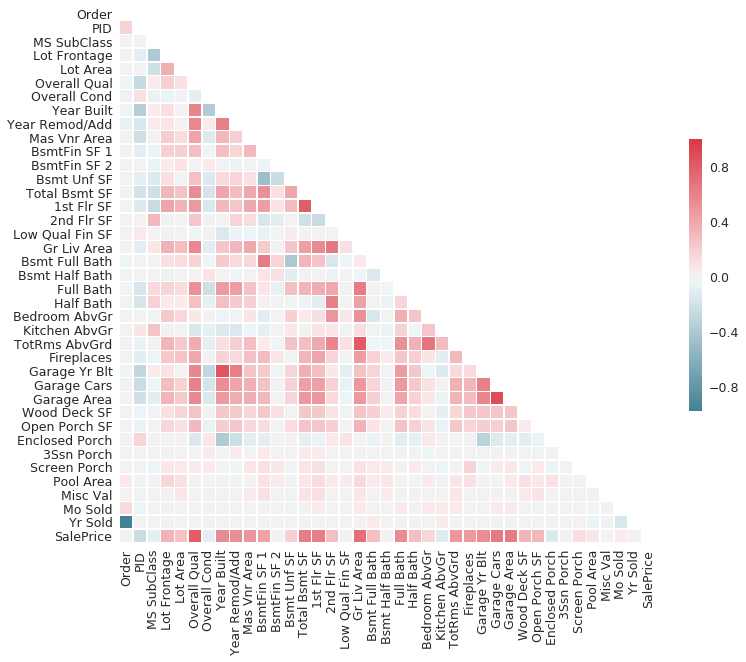

In [321]:
corr = housing.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Special Cases

Electrical

Bsmt Half Bath
Bsmt Full Bath
Garage Cars